Importamos las librerías necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cornac
from cornac.data import Reader
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, Precision, MAE, RMSE

Crear un modelo propio

In [2]:
class MeanRecommender(cornac.models.Recommender):
    def __init__(self, name="MeanRecommender"):
        super().__init__(name=name)
        self.item_means = None

    def fit(self, train_set, val_set):
        super().fit(train_set, val_set)
        # Calcular la media de las calificaciones para cada ítem
        self.item_means = np.zeros(train_set.num_items)
        for i in range(train_set.num_items):
            ratings = train_set.matrix[:, i].data
            if len(ratings) > 0:
                self.item_means[i] = np.mean(ratings)
            else:
                self.item_means[i] = 0

    def score(self, user_id, item_id=None):
        if item_id is None:
            return self.item_means
        return self.item_means[item_id]

Cargar el dataset de MovieLens 100K

In [3]:
data = movielens.load_feedback()

Definir el método de evaluación

In [4]:
ratio_split = RatioSplit(data=data, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1654
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1654
Number of ratings = 19970
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1654


Definir los modelos a emplear

In [5]:
mean_recommender = MeanRecommender() # Modelo propio
mf = cornac.models.MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
bpr = cornac.models.BPR(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
wmf = cornac.models.WMF()
svd = cornac.models.SVD()

Definir las metricas a utilizar

In [6]:
metrics = []
metrics.append(MAE())
metrics.append(RMSE())
metrics.append(Recall(10))
metrics.append(Precision(10))

Definir el experimento con el modelo propio


In [7]:
experiment = cornac.Experiment(eval_method=ratio_split, models=[mean_recommender, mf, bpr, wmf, svd], metrics=metrics)

Ejecutar el experimento

In [8]:
experiment.run()


[MeanRecommender] Training started!

[MeanRecommender] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[WMF] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[SVD] Training started!

[SVD] Evaluation started!


Rating:   0%|          | 0/19970 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


TEST:
...
                |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
--------------- + ------ + ------ + ------------ + --------- + --------- + --------
MeanRecommender | 0.8202 | 0.9810 |       0.0001 |    0.0000 |    0.2596 |   0.5176
MF              | 0.7339 | 0.8923 |       0.0691 |    0.0482 |    0.0556 |   1.0078
BPR             | 2.1623 | 2.3590 |       0.1149 |    0.1173 |    0.1060 |   0.7659
WMF             | 1.0895 | 1.3055 |       0.2013 |    0.2174 |   11.7295 |   1.0684
SVD             | 0.7425 | 0.9015 |       0.0621 |    0.0442 |    0.1171 |   1.2086



Extraer los resultados de las métricas

In [9]:
results = experiment.result
mf_mae = results[0].metric_avg_results['MAE']
mf_rmse = results[0].metric_avg_results['RMSE']
bpr_mae = results[1].metric_avg_results['MAE']
bpr_rmse = results[1].metric_avg_results['RMSE']
wmf_mae = results[2].metric_avg_results['MAE']
wmf_rmse = results[2].metric_avg_results['RMSE']
svd_mae = results[3].metric_avg_results['MAE']
svd_rmse = results[3].metric_avg_results['RMSE']
svd_precision = results[3].metric_avg_results['Precision@10']

Crear un gráfico de barras para mostrar los resultados

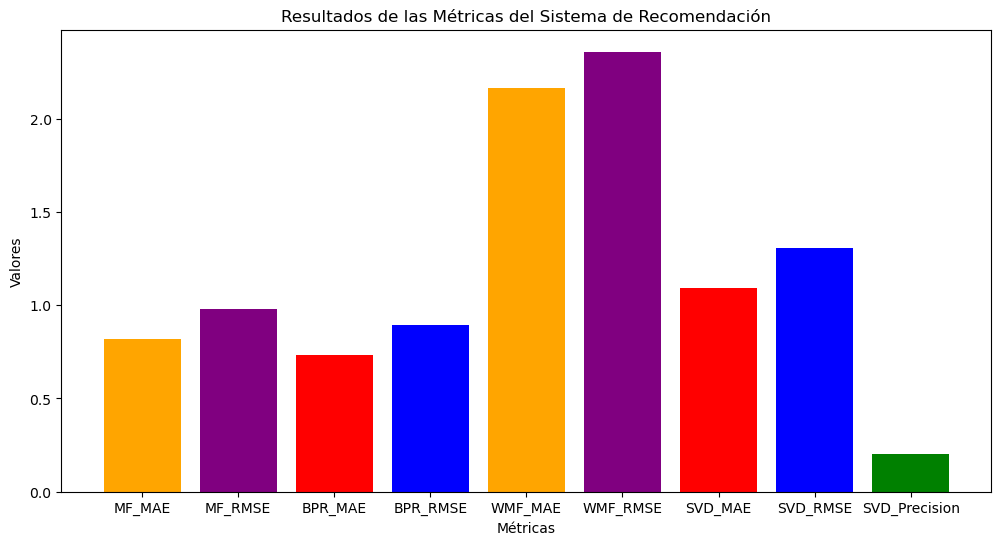

In [10]:
metrics_names = ['MF_MAE', 'MF_RMSE', 'BPR_MAE', 'BPR_RMSE', 'WMF_MAE', 'WMF_RMSE', 'SVD_MAE', 'SVD_RMSE', 'SVD_Precision']
values = [mf_mae, mf_rmse, bpr_mae, bpr_rmse, wmf_mae, wmf_rmse, svd_mae, svd_rmse, svd_precision]

plt.figure(figsize=(12, 6))
plt.bar(metrics_names, values, color=['orange', 'purple', 'red', 'blue', 'orange', 'purple', 'red', 'blue', 'green'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados de las Métricas del Sistema de Recomendación')
plt.show()
